In [1]:
## Beta recommender system

In [2]:
import pandas as pd
import numpy as np

In [3]:
%%time
# Load reviews
reviews = pd.read_csv('../data/yelp_reviews_restaurant.csv')
reviews.head()

Wall time: 1min 6s


,user_id,business_id,review_stars,useful,funny,cool,text,date,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
0,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11,Liberty Village Market & Cafe,65 Jefferson Avenue,Toronto,ON,M6K 1Y3,43.637885,-79.421223,3.5,20,"{'RestaurantsAttire': ""u'casual'"", 'GoodForKid...",American
1,zFCuveEe6M-ijY1iy23IJg,HQl28KMwrEKHqhFrrDqVNQ,5,6,2,5,"We walked into Melt. ""Did you want to put your...",2011-08-25 04:24:23,Liberty Village Market & Cafe,65 Jefferson Avenue,Toronto,ON,M6K 1Y3,43.637885,-79.421223,3.5,20,"{'RestaurantsAttire': ""u'casual'"", 'GoodForKid...",American
2,4V985R3RG-rv0B7WCPQzeQ,HQl28KMwrEKHqhFrrDqVNQ,1,1,0,0,I commented on how slow the service was last A...,2015-03-04 20:37:43,Liberty Village Market & Cafe,65 Jefferson Avenue,Toronto,ON,M6K 1Y3,43.637885,-79.421223,3.5,20,"{'RestaurantsAttire': ""u'casual'"", 'GoodForKid...",American
3,nFGcoL6wuPQzxsNJVSfGrA,HQl28KMwrEKHqhFrrDqVNQ,4,2,0,0,We walked in off the streets on a September ni...,2014-09-10 01:38:55,Liberty Village Market & Cafe,65 Jefferson Avenue,Toronto,ON,M6K 1Y3,43.637885,-79.421223,3.5,20,"{'RestaurantsAttire': ""u'casual'"", 'GoodForKid...",American
4,CJqgUQeWhdgbDyLAFy7xvQ,HQl28KMwrEKHqhFrrDqVNQ,4,0,0,0,Brunch on Saturday was excellent. The Bloody M...,2018-01-21 18:50:29,Liberty Village Market & Cafe,65 Jefferson Avenue,Toronto,ON,M6K 1Y3,43.637885,-79.421223,3.5,20,"{'RestaurantsAttire': ""u'casual'"", 'GoodForKid...",American


In [4]:
# As seen is the EDA, there are a lot of users which does very few reviews. 
# That makes really difficult to classify and with the big amount of data, it is also needed to remove some values. 
# Therefore in order to be in the model, a threshold of 50 reviews/user has been selected. 

In [5]:
# Remove users that have less than 50 reviews.
grouped_users = reviews.groupby('user_id')['text'].count().reset_index()
grouped_users.head()

,user_id,text
0,---1lKK3aKOuomHnwAkAow,23
1,---94vtJ_5o_nikEs6hUjg,1
2,---RfKzBwQ8t3wu-LXvx3w,1
3,---tGbMnMitD_7srW6Nfzg,1
4,---udAKDsn0yQXmzbWQNSw,1


In [6]:
result = grouped_users.query('text <= 50')
result['text'].sum()

2551372

In [7]:
reviews.shape[0]

2841386

In [8]:
print(f'Difference: {reviews.shape[0] - result["text"].sum()}')

Difference: 290014


In [9]:
reviews_filtered = reviews[['user_id', 'name', 'review_stars']][~reviews['user_id'].isin(result['user_id'])]
reviews_filtered.shape

(290013, 3)

## Recommender system using reviews as values

In [10]:
## Utility matrix for users (for restaurants take utility_matrix.T)
from scipy.sparse import csr_matrix

utility_matrix = reviews_filtered.pivot_table(index='user_id', values='review_stars', columns='name').fillna(0)
um = csr_matrix(utility_matrix) 

In [11]:
restaurant_ids = (utility_matrix.columns)
users_ids = (utility_matrix.index)

In [12]:
# Normalizing the data

sum_ratings_per_restaurant = um.sum(axis=0)
n_ratings_per_restaurant = um.getnnz(axis=0)
mean_rating_per_restaurant = sum_ratings_per_restaurant / n_ratings_per_restaurant

In [13]:
um_mean_restaurant = np.tile(mean_rating_per_restaurant, (um.shape[0],1))
um_mean_restaurant.shape

(3346, 13284)

In [14]:
um_norm = um - csr_matrix(um_mean_restaurant)

In [15]:
# Comparing after and before normalizing

um.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 4., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
um_norm.todense()

matrix([[-2.625     , -4.15126812, -3.        , ..., -4.        ,
         -5.        , -4.5       ],
        [-2.625     , -4.15126812, -3.        , ..., -4.        ,
         -5.        , -4.5       ],
        [-2.625     , -4.15126812, -3.        , ..., -4.        ,
         -5.        , -4.5       ],
        ...,
        [-2.625     , -0.15126812, -3.        , ..., -4.        ,
         -5.        , -4.5       ],
        [-2.625     , -4.15126812, -3.        , ..., -4.        ,
         -5.        , -4.5       ],
        [-2.625     , -4.15126812, -3.        , ..., -4.        ,
         -5.        , -4.5       ]])

In [17]:
# create the cosine_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(um_norm, um_norm)

In [18]:
## Restaurant recomendation (item-item) with k-NN

In [19]:
from sklearn.neighbors import NearestNeighbors

In [32]:
names = reviews_filtered['name']
restaurant_ids = reviews_filtered.index

def recommendations(restaurant, distance, k=10):
    correct_name = reviews_filtered[reviews_filtered.name.str.contains(restaurant)]['name'].values[0]
    idx = restaurant_ids.get_loc(reviews_filtered[reviews_filtered.name.str.contains(restaurant)]['name'].index[0])
    
    sim_scores = list(enumerate(distance[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:k]
    
    similar_restaurants = [i[0] for i in sim_scores]
    
    print(f'Recommendations for {correct_name}')
    return reviews_filtered['name'].iloc[similar_restaurants]

In [21]:
recommendations('Liberty', cosine_sim, k=20)

Recommendations for Liberty Village Market & Cafe


32268             Picanha Steak Truck
19286       The Smashed Pig Gastropub
161                         Pink Taco
13043                     Sunset Room
7210              Village Pub & Poker
1975           Brevard Court Sundries
18142           Riva by Wolfgang Puck
6417                    Tam's Kitchen
3256                Cafe des Artisans
32293           Mi Casa Grill Cantina
6888                   Salty Senorita
10181             Putter's Charleston
31385                   El Pollo Loco
11199            Rimrock Bar & Grille
27584    Brooklyn V's Pizza- Chandler
12025                 Jasmine Express
20566       Dairy Queen Grill & Chill
35223                   Bombay Palace
1099       Sabor Miami Cafe & Gallery
Name: name, dtype: object

In [34]:
recommendations('Pollo Loco', cosine_sim, k=15)

Recommendations for El Pollo Loco


26554                            TGI Fridays
19287              The Smashed Pig Gastropub
10057                           Safari Miles
16781                              China Wok
28203    Restaurant - Auberge du Lac Morency
3534              Eighty Acres Kitchen & Bar
10181                    Putter's Charleston
31438                    Blue Burrito Grille
15842                     Orient Sushi Grill
1739                             Smashburger
835                         Red White & Brew
12772                     Pasture and Plenty
2443                  Little Country Kitchen
2845                                Jia Cafe
Name: name, dtype: object

In [33]:
reviews_filtered[reviews_filtered.name.str.contains('Pollo Loco')]['name'].values[0]

'El Pollo Loco'

### Dimension reduction

In [152]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

def optimal_dimensions_svd(matrix):
    n_comp = [2,4,7,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500,4000] # list containing different values of components
    explained = [] # explained variance ratio for each component of Truncated SVD
    for x in n_comp:
        svd = TruncatedSVD(n_components=x, n_iter=10)
        svd.fit(matrix)
        explained.append(svd.explained_variance_ratio_.sum())
        print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
    plt.plot(n_comp, explained)
    plt.xlabel('Number of components')
    plt.ylabel("Explained Variance")
    plt.title("Plot of Number of components v/s explained variance")
    plt.show()

In [36]:
cosine_sim.shape[0]

3346

Number of components = 2 and explained variance = 0.9798052494151198
Number of components = 4 and explained variance = 0.9869873055228444
Number of components = 7 and explained variance = 0.9895629767843342
Number of components = 10 and explained variance = 0.9906388319178469
Number of components = 15 and explained variance = 0.9917196930004503
Number of components = 20 and explained variance = 0.9923910443700577
Number of components = 50 and explained variance = 0.9943271293240076
Number of components = 100 and explained variance = 0.9956435963519542
Number of components = 150 and explained variance = 0.9963882366515864
Number of components = 200 and explained variance = 0.9969228634863487
Number of components = 500 and explained variance = 0.998536896129274
Number of components = 700 and explained variance = 0.9990322105252956
Number of components = 800 and explained variance = 0.9992047727643639
Number of components = 900 and explained variance = 0.9993439281337252
Number of compone

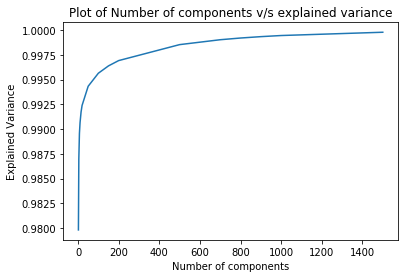

In [41]:
optimal_dimensions_svd(cosine_sim)

In [ ]:
# The selected number is 10 which explains a 99% of the variance.

In [116]:
svd = TruncatedSVD(n_components=10, n_iter=10)
Z = svd.fit_transform(cosine_sim)

### Predicting missing ratings to generate top N recommendations

In [117]:
new_X = svd.inverse_transform(Z).T

In [156]:
def user_recomendations(user_id, k=10):
    idx_loc = utility_matrix.index.get_loc(user_id)
    rec = pd.DataFrame(list(zip(reviews_filtered['name'], 
                                utility_matrix.loc[user_id], 
                                cf_inv[idx_loc, :])), 
                       columns=['restaurant', 'stars', 'pred'])
    return rec[rec.stars==0].sort_values('pred', ascending=False).head(k)

In [157]:
user_recomendations('zFCuveEe6M-ijY1iy23IJg')

,restaurant,stars,pred
3321,Tank's Tap,0.0,4.987479
1210,PT's Gold,0.0,4.545156
2964,Jo Jo's Grill,0.0,4.499795
2766,Chart House,0.0,4.003564
3138,Otro Cafe,0.0,3.940380
1963,PT's Gold,0.0,3.915811
1878,Taco Bell,0.0,3.879169
1714,Filiberto's Mexican Food,0.0,3.751223
2222,Egg N' Joe,0.0,3.750555
421,Brooklyn V's Pizza- Chandler,0.0,3.004977


In [158]:
user_recomendations('--Qh8yKWAvIP4V4K8ZPfHA')

,restaurant,stars,pred
3105,Fatburger,0.0,5.099558
2496,Evan's Old Town Grille,0.0,5.085459
386,Sandwich Max,0.0,5.059301
842,Otro Cafe,0.0,5.056131
283,Zam Zam Tikka & Kabab,0.0,5.050993
2261,Raxx-,0.0,5.047137
3318,Tank's Tap,0.0,5.045739
1629,Involtini Ristorante,0.0,5.044460
948,Farmer Boys,0.0,5.041420
488,D'Agnese's Bistro Seven Hills,0.0,5.035256


In [159]:
user_recomendations('-0b84SUGVN0YkG5j2MCmBw')

,restaurant,stars,pred
2721,Sunset Room,0.0,2.992291
194,Little Country Kitchen,0.0,0.014652
840,Otro Cafe,0.0,0.012284
212,The Jailhouse Taverne,0.0,0.011870
976,Chand Palace,0.0,0.010853
1233,Mariner's Inn,0.0,0.010823
352,Pizza Taglio,0.0,0.010706
1749,Riva by Wolfgang Puck,0.0,0.010028
655,Mad Jack's Grill & Pub,0.0,0.009456
741,New China Buffet,0.0,0.008988


In [86]:
utility_matrix.loc['zFCuveEe6M-ijY1iy23IJg']

name
 China                                 0.0
&Company Resto Bar                     0.0
1 Pot                                  0.0
100th Bomb Group                       0.0
107 State                              0.0
                                      ... 
Ã”Breton                               0.0
Ã‰rabliÃ¨re Ã  la Feuille d'Ã‰rable    0.0
Ã‰tat-Major                            0.0
Ã‰tudiant Savoureux Biryani            0.0
Å’ufs & Cie                            0.0
Name: zFCuveEe6M-ijY1iy23IJg, Length: 13284, dtype: float64

In [89]:
utility_matrix.index.get_loc('zFCuveEe6M-ijY1iy23IJg')

3309

In [138]:
new_X[3309, :]

array([ 0.02220042,  0.01534646, -0.00489837, ...,  0.01249355,
        0.0173638 ,  0.01453143])

In [114]:
utility_matrix.head()

name,China,&Company Resto Bar,1 Pot,100th Bomb Group,107 State,111 Bistro,1118 Bistro Bar and Grill,1130 The Restaurant,12 Tables,123 Bulgogi,...,tÃ¤kÅ�,yuan yuan Chinese Restaurant,z-teca Gourmet Burritos,zuma,ÃŽle Flottante,Ã”Breton,Ã‰rabliÃ¨re Ã la Feuille d'Ã‰rable,Ã‰tat-Major,Ã‰tudiant Savoureux Biryani,Å’ufs & Cie
user_id,,,,,,,,,,,,,,,,,,,,,
--2HUmLkcNHZp0xw6AMBPg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
--Qh8yKWAvIP4V4K8ZPfHA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0b84SUGVN0YkG5j2MCmBw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0udWcFQEt2M8kM3xcIofw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-267Yx8RmdP6io2-qI4UcQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
cosine_sim

array([[1.        , 0.99497362, 0.9949246 , ..., 0.99489564, 0.99416601,
        0.99572388],
       [0.99497362, 1.        , 0.99535623, ..., 0.9949953 , 0.99430984,
        0.99608304],
       [0.9949246 , 0.99535623, 1.        , ..., 0.9950705 , 0.99430149,
        0.99602038],
       ...,
       [0.99489564, 0.9949953 , 0.9950705 , ..., 1.        , 0.99514317,
        0.995786  ],
       [0.99416601, 0.99430984, 0.99430149, ..., 0.99514317, 1.        ,
        0.99494936],
       [0.99572388, 0.99608304, 0.99602038, ..., 0.995786  , 0.99494936,
        1.        ]])

In [ ]:
# Reminder: Apply the algorith (SVD) to the utility matrix, not de cosine_sim distance!!!!

Number of components = 2 and explained variance = 0.035505301342141894
Number of components = 4 and explained variance = 0.0626509933925302
Number of components = 7 and explained variance = 0.08518204117363623
Number of components = 10 and explained variance = 0.09961069555750254
Number of components = 15 and explained variance = 0.1185596907186402
Number of components = 20 and explained variance = 0.1339563102838302
Number of components = 50 and explained variance = 0.19864619752847112
Number of components = 100 and explained variance = 0.2678198606872778
Number of components = 150 and explained variance = 0.3203324550802516
Number of components = 200 and explained variance = 0.36496172878485034
Number of components = 500 and explained variance = 0.5534758872292634
Number of components = 700 and explained variance = 0.6397686417424235
Number of components = 800 and explained variance = 0.6758848209971879
Number of components = 900 and explained variance = 0.7083455127523354
Number of 

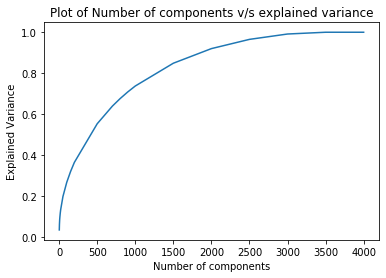

In [153]:
# The number of components has increased... now are 3000
optimal_dimensions_svd(utility_matrix)

In [154]:
svd = TruncatedSVD(n_components=3000, n_iter=10)
cf = svd.fit_transform(utility_matrix)

In [155]:
cf_inv = svd.inverse_transform(cf).T
cf_inv

array([[ 8.05997687e-03,  7.77090126e-03,  9.71653583e-03, ...,
        -2.73088167e-02,  2.06929610e-02,  5.91624054e-03],
       [-1.16357897e-02,  1.94846589e-02,  8.83590595e-04, ...,
         4.01343802e+00, -3.39522415e-02, -9.83460035e-04],
       [ 2.48816765e-03,  1.49653339e-03,  5.36508734e-04, ...,
         2.67422206e-03,  2.34561117e-03,  3.71483138e-03],
       ...,
       [-3.56916406e-03, -5.50463623e-03,  6.48059855e-03, ...,
         9.32666112e-03,  4.20730581e-03, -1.49114530e-03],
       [ 1.14906832e-04, -1.11474032e-03,  2.97721711e-03, ...,
        -4.22731515e-04, -5.58628756e-03,  9.26927868e-04],
       [ 4.66775952e-03,  8.05112232e-03,  5.03136440e-03, ...,
        -7.68394998e-03, -7.81623217e-03,  1.08584613e-02]])

In [166]:
# Evaluation metrics

#from funcsigs import signature
import recmetrics
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

In [167]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(reviews_filtered, reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [171]:
# train SVD recommender

algo = SVD(n_factors=3000, n_epochs=10)
algo.fit(trainset)

In [172]:
# make predictions on test set

test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userid', 'restaurant', 'actual', 'cf_predictions']
test.head()

,userid,restaurant,actual,cf_predictions
0,sjWvk3DZapZ-9ULAFtDmYw,Bojangles' Famous Chicken 'n Biscuits,4.0,2.705372
1,7dnh9OrD8LekBwvachGH5Q,The Rigby Pub And Grill,3.0,2.668738
2,pMefTWo6gMdx8WhYSA2u3w,Sushi-to,4.0,2.064321
3,2vJ2e51kdbdAmAo_HTr4KQ,Mr. ChopStix,4.0,2.908752
4,4hBhtCSgoxkrFgHa4YAD-w,Pomodoro Italian Kitchen,4.0,3.026066


In [177]:
# evaluate model with MSE and RMSE

print(f'MSE: {recmetrics.mse(test.actual, test.cf_predictions)}')
print(f'RMSE: {recmetrics.rmse(test.actual, test.cf_predictions)}')

MSE: 1.2401169643411953
RMSE: 1.1136053898671627


In [182]:
# create matrix of predicted values

cf_model = test.pivot(index='userid', columns='restaurant', values='cf_predictions').fillna(0)

ValueError: Index contains duplicate entries, cannot reshape

In [183]:
test

,userid,restaurant,actual,cf_predictions
0,sjWvk3DZapZ-9ULAFtDmYw,Bojangles' Famous Chicken 'n Biscuits,4.0,2.705372
1,7dnh9OrD8LekBwvachGH5Q,The Rigby Pub And Grill,3.0,2.668738
2,pMefTWo6gMdx8WhYSA2u3w,Sushi-to,4.0,2.064321
3,2vJ2e51kdbdAmAo_HTr4KQ,Mr. ChopStix,4.0,2.908752
4,4hBhtCSgoxkrFgHa4YAD-w,Pomodoro Italian Kitchen,4.0,3.026066
...,...,...,...,...
72499,TJNkg75ODHabE5GBfV5wRQ,Biscuits,5.0,3.504009
72500,D2ljL5ejuqpa4f8fnZ1qjw,East Side Mario's,5.0,3.976322
72501,YBT3EKUNN4IP8m4x7sGu1g,Panda Express,5.0,4.107673
72502,hPtsSzp5ymjJU9h-6QAoXA,Oja Noodles House,4.0,4.235665


In [181]:
test[test.duplicated()]

,userid,restaurant,actual,cf_predictions
3730,4IZxXA8XxeUXEjNf6yZamw,Chipotle Mexican Grill,3.0,2.451027
3738,tBANVdxh_if10BXv6YsLmg,The Main Ingredient Ale House And CafÃ©,5.0,3.301571
4477,z_tqPytGQF_tDw_buHKJcw,Alquisiras Paleteria,4.0,4.755405
4494,U4INQZOPSUaj8hMjLlZ3KA,Crisp,5.0,4.971641
4768,cyuDrrG5eEK-TZI867MUPA,Wokin Express,3.0,3.131891
...,...,...,...,...
72442,-aV7azrzW2rlAm6G4DA-cw,Enigma Coffee and Food,5.0,4.950662
72455,JjrpeIkmuhk9Ab_5HEsqyw,Villa Italian Kitchen,4.0,3.183144
72466,qKJEQrFtW33HWqKzvn3U4A,Choolaah Indian BBQ,3.0,3.319245
72477,WfZFj0OH9tuOdxEfSaM1vA,Mesquite Grille,5.0,4.186807


## Recommender system using NLP